In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import contractions
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer 
import re
from sklearn.feature_extraction.text import TfidfVectorizer as tf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
import seaborn as sns
import warnings
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [2]:
warnings.filterwarnings('ignore')

In [3]:
df=pd.read_csv('train.csv',encoding='unicode_escape')
df.head()

textID                                               text  \
0  cb774db0d1                I`d have responded, if I were going   
1  549e992a42      Sooo SAD I will miss you here in San Diego!!!   
2  088c60f138                          my boss is bullying me...   
3  9642c003ef                     what interview! leave me alone   
4  358bd9e861   Sons of ****, why couldn`t they put them on t...   

                         selected_text sentiment Time of Tweet Age of User  \
0  I`d have responded, if I were going   neutral       morning        0-20   
1                             Sooo SAD  negative          noon       21-30   
2                          bullying me  negative         night       31-45   
3                       leave me alone  negative       morning       46-60   
4                        Sons of ****,  negative          noon       60-70   

       Country  Population -2020  Land Area (Km²)  Density (P/Km²)  
0  Afghanistan          38928346         652860.0               60  
1      Albania           2877797          27400.0              105  
2      Algeria          43851044        2381740.0               18  
3      Andorra             77265            470.0              164  
4       Angola          32866272        1246700.0               26

In [4]:
test_data = pd.read_csv('test.csv',encoding='unicode_escape')

In [5]:
df.isna().sum()

textID              0
text                1
selected_text       1
sentiment           0
Time of Tweet       0
Age of User         0
Country             0
Population -2020    0
Land Area (Km²)     0
Density (P/Km²)     0
dtype: int64

since there are very less nan values so we can drop those rows which are nan

In [6]:
df.dropna(inplace=True)

In [7]:
test_data.dropna(inplace=True)

In [8]:
df['Age of User']

0          0-20
1         21-30
2         31-45
3         46-60
4         60-70
          ...  
27476     31-45
27477     46-60
27478     60-70
27479    70-100
27480      0-20
Name: Age of User, Length: 27480, dtype: object

In [9]:
df["sentiment"].unique()

array(['neutral', 'negative', 'positive'], dtype=object)

There are 3 types of sentiments in the dataset

In [10]:
df["Age of User"].unique()

array(['0-20', '21-30', '31-45', '46-60', '60-70', '70-100'], dtype=object)

In [11]:
age_labels ={'0-20':0, '21-30':20, '31-45':31, '46-60':46, '60-70':60, '70-100':70}
df["Age of User"] = df["Age of User"].map(age_labels)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27480 entries, 0 to 27480
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   textID            27480 non-null  object 
 1   text              27480 non-null  object 
 2   selected_text     27480 non-null  object 
 3   sentiment         27480 non-null  object 
 4   Time of Tweet     27480 non-null  object 
 5   Age of User       27480 non-null  int64  
 6   Country           27480 non-null  object 
 7   Population -2020  27480 non-null  int64  
 8   Land Area (Km²)   27480 non-null  float64
 9   Density (P/Km²)   27480 non-null  int64  
dtypes: float64(1), int64(3), object(6)
memory usage: 2.3+ MB


In [13]:
# There is no significance of this column
df.drop(["textID"],axis=1,inplace=True)
test_data.drop(["textID"],axis=1,inplace=True)

In [14]:
df.head()

text  \
0                I`d have responded, if I were going   
1      Sooo SAD I will miss you here in San Diego!!!   
2                          my boss is bullying me...   
3                     what interview! leave me alone   
4   Sons of ****, why couldn`t they put them on t...   

                         selected_text sentiment Time of Tweet  Age of User  \
0  I`d have responded, if I were going   neutral       morning            0   
1                             Sooo SAD  negative          noon           20   
2                          bullying me  negative         night           31   
3                       leave me alone  negative       morning           46   
4                        Sons of ****,  negative          noon           60   

       Country  Population -2020  Land Area (Km²)  Density (P/Km²)  
0  Afghanistan          38928346         652860.0               60  
1      Albania           2877797          27400.0              105  
2      Algeria          43851044        2381740.0               18  
3      Andorra             77265            470.0              164  
4       Angola          32866272        1246700.0               26

<Axes: xlabel='sentiment', ylabel='count'>

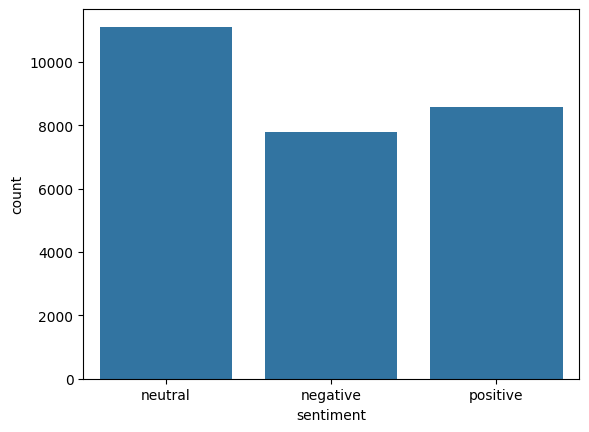

In [15]:
sns.countplot(x=df['sentiment'])

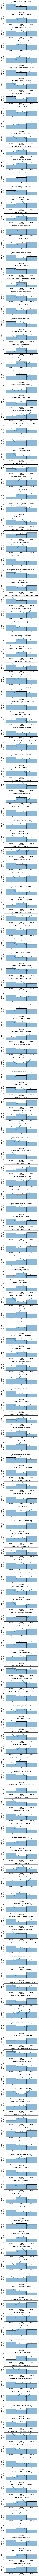

In [16]:
grouped = df.groupby('Country')

# Create a figure with subplots
fig, axs = plt.subplots(len(grouped), 1, figsize=(6, 2*len(grouped)))

# Iterate over each group
for i, (country, data) in enumerate(grouped):
    # Plot histogram for sentiment distribution for the current country
    sns.histplot(data['sentiment'], ax=axs[i], kde=True)
    axs[i].set_title(f'Sentiment Distribution for {country}')
    axs[i].set_xlabel('Sentiment')
    axs[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

No dependendecy on Country . Almost all are distributed uniformly

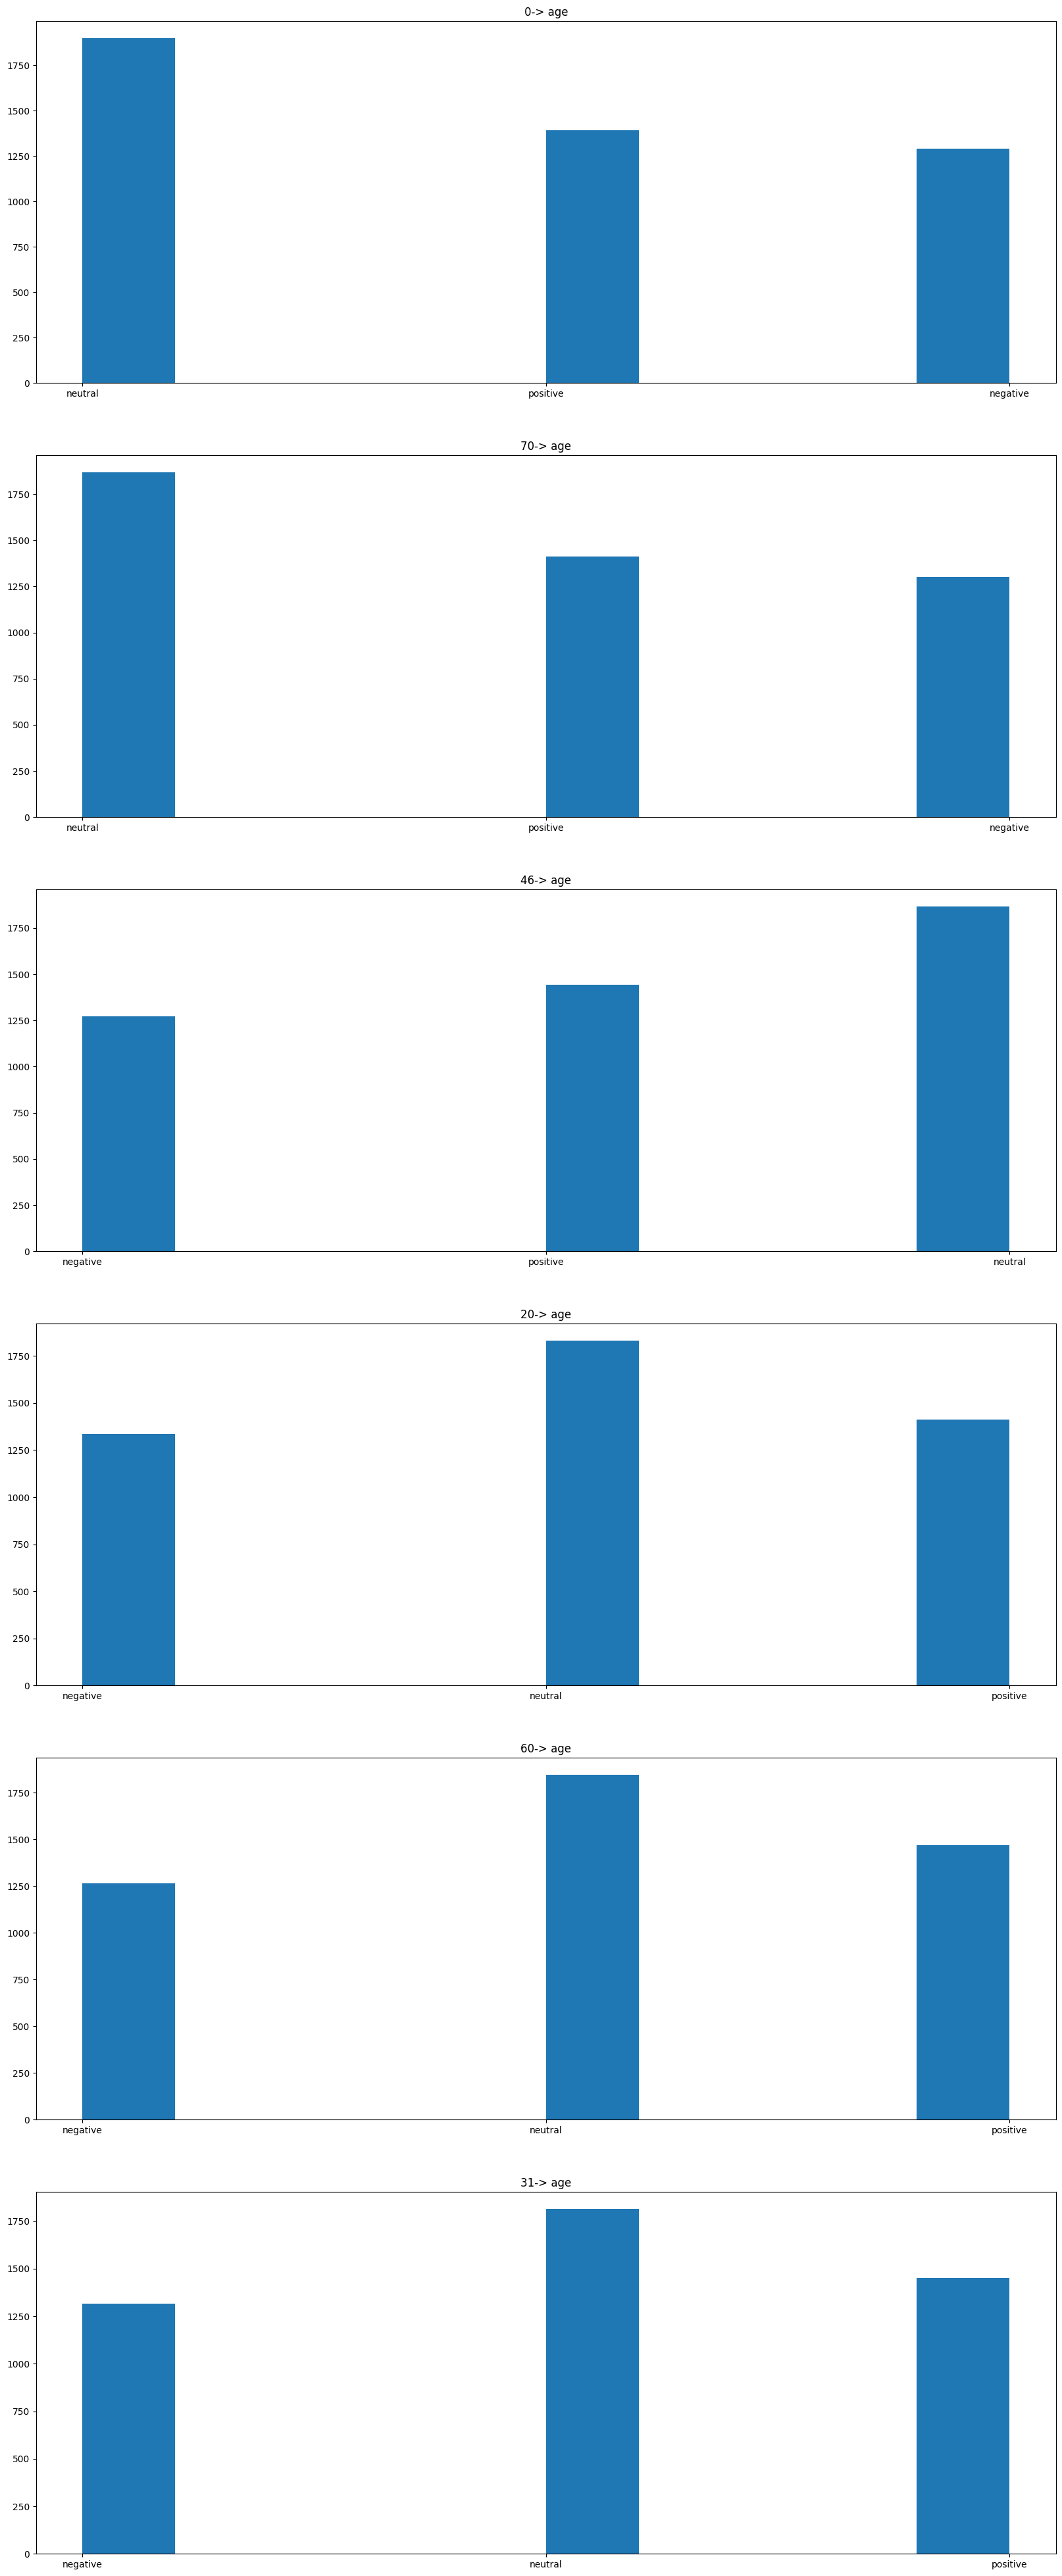

In [16]:
age=set(df['Age of User'])
age=list(age)
temp_df=[0]*len(age)
for i,ages in enumerate(age):
    temp_df[i]=df[df['Age of User']==ages]
fig=plt.figure(figsize=(20,50))
ax2 = fig.subplots(6,1)
for i in range(6):
    ax2[i].hist(temp_df[i]['sentiment'])
    ax2[i].set_title(str(age[i])+'-> age')
        # ax1[i,j].

evenly distribution of sentiment inn age but it is slighly titled toward neutral 

In [17]:
df.drop(labels=['Country'],inplace=True,axis=1)
df.drop(labels=['Age of User'],axis=1,inplace=True)

test_data.drop(labels=['Country'],inplace=True,axis=1)
test_data.drop(labels=['Age of User'],axis=1,inplace=True)

In [18]:
df.duplicated().any()

False

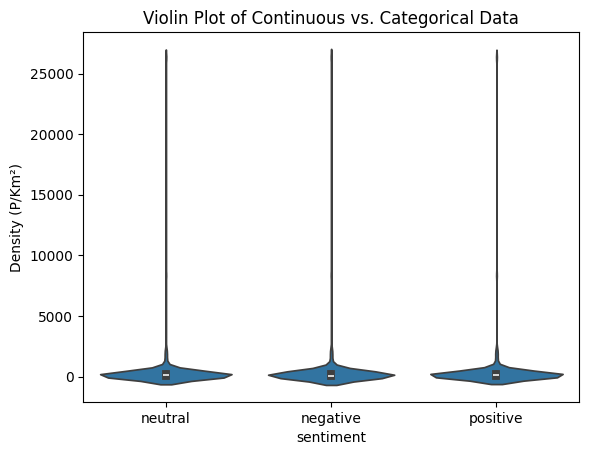

In [19]:
sns.violinplot(x='sentiment', y='Density (P/Km²)', data=df)
plt.xlabel('sentiment')
plt.ylabel('Density (P/Km²)')
plt.title('Violin Plot of Continuous vs. Categorical Data')
plt.show()

As we can see that the median represented vy white dot is same for all the sentiment accross distribution so the Density does not  add any new information.

In [19]:
df.drop(['Density (P/Km²)'],inplace=True,axis=1)
test_data.drop(['Density (P/Km²)'],inplace=True,axis=1)

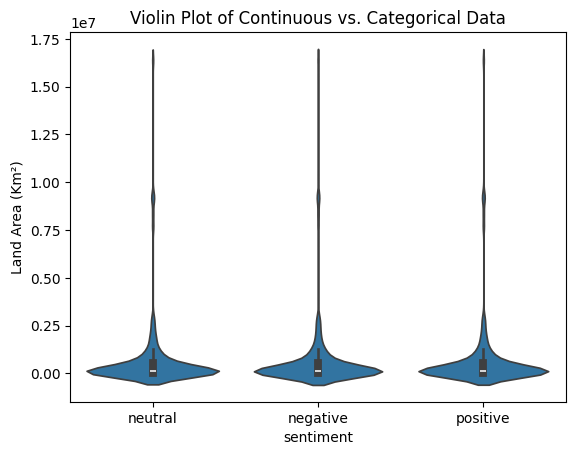

In [21]:
sns.violinplot(x='sentiment', y='Land Area (Km²)', data=df)
plt.xlabel('sentiment')
plt.ylabel('Land Area (Km²)')
plt.title('Violin Plot of Continuous vs. Categorical Data')
plt.show()

In [20]:
df.drop(['Land Area (Km²)'],inplace=True,axis=1)
test_data.drop(['Land Area (Km²)'],inplace=True,axis=1)

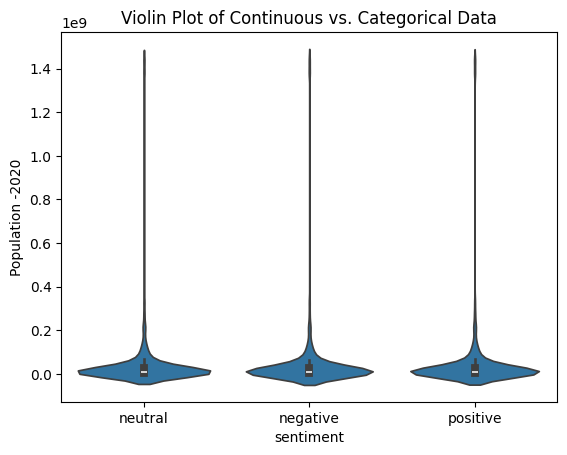

In [23]:
sns.violinplot(x='sentiment', y='Population -2020', data=df)
plt.xlabel('sentiment')
plt.ylabel('Population -2020')
plt.title('Violin Plot of Continuous vs. Categorical Data')
plt.show()

In [21]:
df.drop(['Population -2020'],axis=1,inplace=True)
test_data.drop(['Population -2020'],inplace=True,axis=1)

In [22]:
df.head()

text  \
0                I`d have responded, if I were going   
1      Sooo SAD I will miss you here in San Diego!!!   
2                          my boss is bullying me...   
3                     what interview! leave me alone   
4   Sons of ****, why couldn`t they put them on t...   

                         selected_text sentiment Time of Tweet  
0  I`d have responded, if I were going   neutral       morning  
1                             Sooo SAD  negative          noon  
2                          bullying me  negative         night  
3                       leave me alone  negative       morning  
4                        Sons of ****,  negative          noon

In [23]:
test_data.head()

text sentiment Time of Tweet
0  Last session of the day  http://twitpic.com/67ezh   neutral       morning
1   Shanghai is also really exciting (precisely -...  positive          noon
2  Recession hit Veronique Branquinho, she has to...  negative         night
3                                        happy bday!  positive       morning
4             http://twitpic.com/4w75p - I like it!!  positive          noon

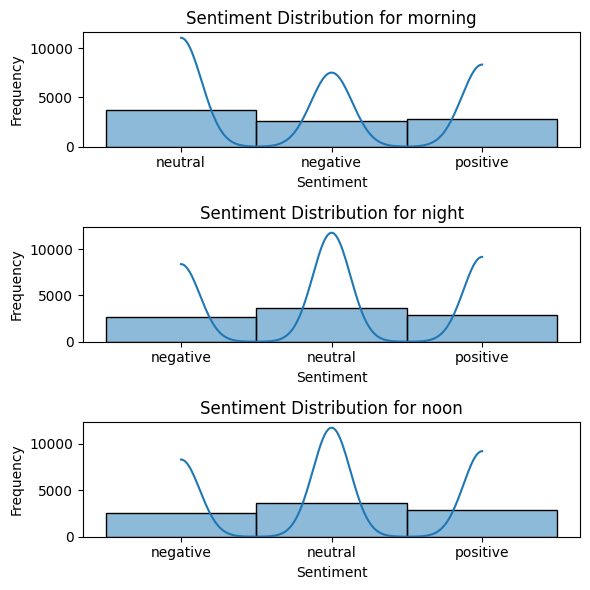

In [26]:
grouped = df.groupby('Time of Tweet')

# Create a figure with subplots
fig, axs = plt.subplots(len(grouped), 1, figsize=(6, 2*len(grouped)))

# Iterate over each group
for i, (country, data) in enumerate(grouped):
    # Plot histogram for sentiment distribution for the current country
    sns.histplot(data['sentiment'], ax=axs[i], kde=True)
    axs[i].set_title(f'Sentiment Distribution for {country}')
    axs[i].set_xlabel('Sentiment')
    axs[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

We can see that there is not much time difference in the sentiment in the Time of Tweet.
So we can reject them as there is not much bisases toward any sentiment among all Tweets

In [24]:
df.drop(["Time of Tweet"],axis=1,inplace=True)
test_data.drop(["Time of Tweet"],axis=1,inplace=True)

In [25]:
df.head()

text  \
0                I`d have responded, if I were going   
1      Sooo SAD I will miss you here in San Diego!!!   
2                          my boss is bullying me...   
3                     what interview! leave me alone   
4   Sons of ****, why couldn`t they put them on t...   

                         selected_text sentiment  
0  I`d have responded, if I were going   neutral  
1                             Sooo SAD  negative  
2                          bullying me  negative  
3                       leave me alone  negative  
4                        Sons of ****,  negative

In [42]:
df_1 = df[['text','sentiment']]
df_2 = df[['selected_text','sentiment']]

test2 = test_data[['text','sentiment']]

In [43]:
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

def textprocessing(text):
    # Convert to lowercase
    text_lower = str(text).lower()
    
    # Remove URLs
    text_no_urls = re.sub(r"https\S+|www\S+|https\S+"," ", text_lower, flags=re.MULTILINE)
    
    # Remove non-alphanumeric characters
    text_no_nonalpha = re.sub("(\\d|\\W)+", " ", text_no_urls)
    
    # Remove '@' and '#' symbols
    text_no_symbols = re.sub(r'\@\w+|\#', " ", text_no_nonalpha)
    
    # Tokenization
    text_tokens = word_tokenize(text_no_symbols)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english')) - {'not','no' , 'never'}
    text_no_stopwords = [word for word in text_tokens if word not in stop_words]
    # text_no_stopwords = text_tokens
    
    # Lemmatization
    lem = SnowballStemmer('english')
    text_lemmatized = [lem.stem(word) for word in text_no_stopwords]
    text_processed = " ".join(text_lemmatized)
    
    return text_processed


In [44]:
df_1['text'] = df_1['text'].apply(textprocessing)
test2['text'] = test2['text'].apply(textprocessing)

In [45]:
df_1.head()

text sentiment
0                     respond go   neutral
1        sooo sad miss san diego  negative
2                     boss bulli  negative
3            interview leav alon  negative
4  son put releas alreadi bought  negative

In [47]:
vector=tf()
x_train = vector.fit_transform(df_1['text'])
x_test = vector.transform(test2["text"])

x_train.shape

(27480, 20046)

In [48]:
x_test.shape

(3534, 20046)

In [49]:
y_train = df_1['sentiment']
y_test = test2["sentiment"]

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the data
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

print("Class Labels:", label_encoder.classes_)
print("Encoded Values:", label_encoder.transform(label_encoder.classes_))
labels_map = {}
for i in range(len(label_encoder.classes_)):
    labels_map[label_encoder.transform(label_encoder.classes_)[i]] = label_encoder.classes_[i]

Class Labels: ['negative' 'neutral' 'positive']
Encoded Values: [0 1 2]


In [50]:
svm = SVC(kernel='rbf')
svm.fit(x_train,y_train)
y_pred = svm.predict(x_test)
accuracy_score(y_test,y_pred)

0.7204301075268817

In [114]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

# Define the model
model = Sequential()

# Add layers with dropout
model.add(Dense(32, activation='relu', input_shape=(x_train.shape[1],)))
model.add(Dropout(0.5))  # Add dropout after the first layer
model.add(Dense(3, activation='softmax'))

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Summary of the model
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 32)                641504    
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 3)                 99        
                                                                 
Total params: 641603 (2.45 MB)
Trainable params: 641603 (2.45 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [115]:
from keras.callbacks import ModelCheckpoint
checkpoint_filepath = 'best_model_weights.h5'

# Define the ModelCheckpoint callback
checkpoint = ModelCheckpoint(filepath=checkpoint_filepath,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')

# Add the checkpoint callback to the list of callbacks
callbacks_list = [checkpoint]

# Train the model with the callbacks
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_test, y_test),
                    callbacks=callbacks_list)

Epoch 1/10


857/859 [============================>.] - ETA: 0s - loss: 0.9083 - accuracy: 0.5881
Epoch 1: val_accuracy improved from -inf to 0.70204, saving model to best_model_weights.h5
859/859 [==============================] - 8s 8ms/step - loss: 0.9079 - accuracy: 0.5883 - val_loss: 0.7285 - val_accuracy: 0.7020
Epoch 2/10
857/859 [============================>.] - ETA: 0s - loss: 0.6791 - accuracy: 0.7299
Epoch 2: val_accuracy improved from 0.70204 to 0.71788, saving model to best_model_weights.h5
859/859 [==============================] - 9s 11ms/step - loss: 0.6792 - accuracy: 0.7298 - val_loss: 0.6768 - val_accuracy: 0.7179
Epoch 3/10
859/859 [==============================] - ETA: 0s - loss: 0.5804 - accuracy: 0.7798
Epoch 3: val_accuracy did not improve from 0.71788
859/859 [==============================] - 10s 12ms/step - loss: 0.5804 - accuracy: 0.7798 - val_loss: 0.6705 - val_accuracy: 0.7145
Epoch 4/10
855/859 [============================>.] - ETA: 0s - loss: 0.5080 - accuracy: 0.

In [116]:
model.load_weights(checkpoint_filepath)
y_pred = []
y_prob = model.predict(x_test)
y_pred = np.argmax(y_prob, axis=1)
accuracy_score(y_test,y_pred)

  1/111 [..............................] - ETA: 11s

111/111 [==============================] - 0s 2ms/step


0.7178834182229767

In [51]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
clf = MultinomialNB(alpha=0.5)
clf.fit(x_train,y_train)
y_pred=clf.predict(x_test)
print(accuracy_score(y_test,y_pred))

0.6301641199773628


In [52]:
from sklearn.linear_model import LogisticRegression
# Initialize LogisticRegressionCV with cross-validation
lr = LogisticRegression(C=1.8,max_iter=200)
lr.fit(x_train,y_train)
y_pred= lr.predict(x_test)
accuracy_validation_lr = accuracy_score(y_test, y_pred)
accuracy_validation_lr

0.711092246745897

In [53]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(x_train, y_train)
y_pred = rf_model.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print("Validation Accuracy:", accuracy)

Validation Accuracy: 0.7164685908319185


In [54]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Define the logistic regression model
lr = LogisticRegression(max_iter=200)

# Define the hyperparameters and their values to be tuned
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'penalty': ['l1', 'l2']}

# Initialize GridSearchCV
grid_search = GridSearchCV(lr, param_grid, cv=5)

# Perform grid search
grid_search.fit(x_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)

# Use the best model for prediction
best_lr = grid_search.best_estimator_
y_pred = best_lr.predict(x_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Best hyperparameters: {'C': 1, 'penalty': 'l2'}
Accuracy: 0.711092246745897


In [125]:
import joblib
# Save the vectorizer
joblib.dump(vector, 'vector.pkl')
joblib.dump(svm, 'model.pkl')

['model.pkl']